## QIB Email Analysis Notebook

### Imports

In [46]:
# Third-Party Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import html2text
from tqdm.notebook import tqdm

# Local imports
from src.config.config import Config
from src.database.database import Database
from src.utils.data_exporter import DataExporter

### Setup

In [47]:
config = Config.from_json('config.json')
database = Database.from_credentials(username=config.db_user, password=config.db_password, host=config.db_host, database=config.db_name)
data_exporter = DataExporter(database)
tqdm.pandas()

htmlConverter = html2text.HTML2Text()
htmlConverter.ignore_links = True
htmlConverter.ignore_images = True

### Retrieve Emails

In [48]:
dfs = data_exporter.to_dfs()
dfs.keys()

dict_keys(['folders', 'addresses', 'messages', 'recipients'])

In [49]:
folders = dfs['folders']
addresses = dfs['addresses']
messages = dfs['messages']
recipients = dfs['recipients']

In [50]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5039 entries, 1 to 5039
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   global_message_id     5039 non-null   object        
 1   folder_id             5039 non-null   int64         
 2   from_address_id       5039 non-null   int64         
 3   provider_email_id     5039 non-null   int64         
 4   creation_time         5039 non-null   datetime64[ns]
 5   submit_time           5039 non-null   datetime64[ns]
 6   delivery_time         5039 non-null   datetime64[ns]
 7   sender_name           5039 non-null   object        
 8   in_reply_to           587 non-null    object        
 9   subject               4923 non-null   object        
 10  plain_text_body       233 non-null    object        
 11  rich_text_body        16 non-null     object        
 12  html_body             4784 non-null   object        
 13  first_in_thread       5

## Preprocessing

### Converting HTML Bodies to Plain Text

In [51]:
# Choose emails with html bodies that don't already have a plain text body then convert them
def process_row(row):
    if pd.isna(row['plain_text_body']):
        if row['html_body'] is not None:
            return htmlConverter.handle(row['html_body'])
        else:
            return None
    else:
        return row['plain_text_body']
    
messages['plain_text_body'] = messages.progress_apply(process_row, axis=1)

  0%|          | 0/5039 [00:00<?, ?it/s]

### Nullifying Emails with Empty Bodies

In [52]:
messages["plain_text_body"] = messages["plain_text_body"].apply(lambda x: None if pd.isna(x) or x.strip() == "" else x)

### Fixing In-Reply-To Values

In [53]:
messages['in_reply_to'] = messages['in_reply_to'].apply(lambda x: x[1:-1] if x else None)

## Investigating Email Bodies

### Types of Email Bodies

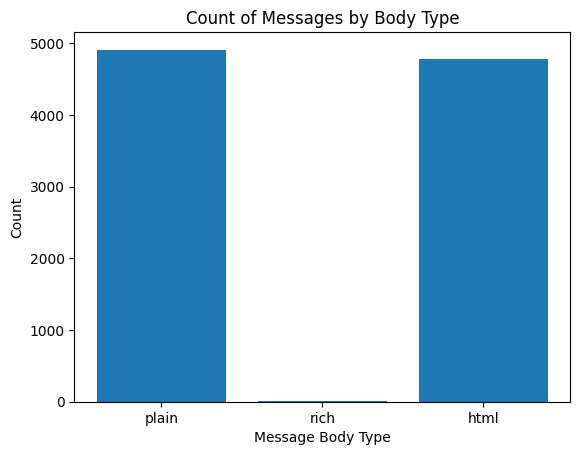

In [54]:
plain_text_body_count = messages['plain_text_body'].notna().sum()
rich_text_body_count = messages['rich_text_body'].notna().sum()
html_body_count = messages['html_body'].notna().sum()
data = [plain_text_body_count, rich_text_body_count, html_body_count]

plt.bar(['plain', 'rich', 'html'], data)
plt.xlabel('Message Body Type')
plt.ylabel('Count')
plt.title('Count of Messages by Body Type')
plt.show()

### Correlation Matrix of Message Body Types

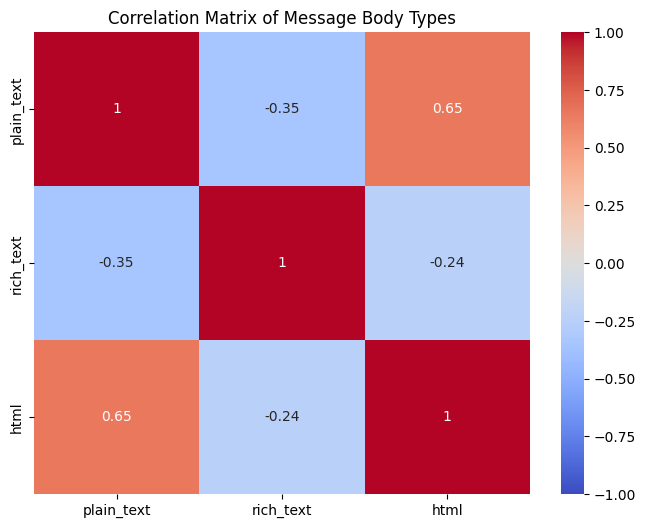

In [55]:
presence_df = pd.DataFrame({
    "plain_text": messages["plain_text_body"].notna(),
    "rich_text": messages["rich_text_body"].notna(),
    "html": messages["html_body"].notna()
})

correlation_matrix = presence_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Message Body Types")
plt.show()

### Sample Emails with only Plain Text Bodies

In [56]:
plain_text_body_values = messages[messages["plain_text_body"].notna()]["plain_text_body"]
print(plain_text_body_values.sample().item())

|  
---  
---  
|  |  |  |  Elinor M. wants to get more active with you on Fitbit.    
  
  
ACCEPT FRIEND  
  
"Join me on Fitbit so we can track each other's progress, send each other
encouragement, and see who tops the leaderboard each week!"  
---  
|  |  |  Elinor M.'s AVERAGE DAILY STEPS   
---  
\--  
|  YOUR AVERAGE DAILY STEPS  
---  
\--  
  
  
  
  
---  
  
Fitbit users with at least one friend tend to be more active than the average
user. Are you ready to step up to the challenge?  
---  
  
|  | TELL FRIENDS & FAMILY YOU'RE ON THE PATH TO FITNESS |  SHARE  |  SHARE   
---|---|---|---|---  
  
Let's be friends  
  
               |  You're receiving this email at belal.mnur@gmail.com because you have   
elected to receive emails for Friend Requests. Not interested anymore?
Unsubscribe.  
Fitbit and the Fitbit Logo are registered trademarks of Fitbit, Inc.  
Fitbit, Inc — 199 Fremont Street San Francisco, CA 94105 USA.  
  
WE'RE HIRING  
  
---  
  

  *[Fee]: Booking Fee

### Sample Emails with only Rich Text Format Bodies

In [57]:
rich_text_body_values = messages[messages["rich_text_body"].notna()]["rich_text_body"]
rich_text_body_values.sample().item()

'{\\rtf1\\ansi\\ansicpg1252\\fromhtml1 \\fbidis \\deff0{\\fonttbl\r\n{\\f0\\fswiss\\fcharset0 Arial;}\r\n{\\f1\\fmodern Courier New;}\r\n{\\f2\\fnil\\fcharset2 Symbol;}\r\n{\\f3\\fmodern\\fcharset0 Courier New;}}\r\n{\\colortbl\\red0\\green0\\blue0;\\red0\\green0\\blue255;\\red255\\green255\\blue255;\\red255\\green0\\blue0;}\r\n\\uc1\\pard\\plain\\deftab360 \\f0\\fs24 \r\n{\\*\\htmltag243 <style type="text/css">}\r\n{\\*\\htmltag243 \\par * \\{\\par     padding: 0;    margin: 0;\\}\\par table \\{\\par \\tab border-collapse: separate; width =100%;\\tab border: 0;\\tab border-spacing: 0;\\}\\par \\par tr \\{\\par \\tab line-height: 18px;\\}\\par \\par a, td \\{\\par \\tab font-size: 14px;\\tab font-family: Arial;\\tab color: #333;\\tab word-wrap: break-word;\\tab word-break: normal;\\tab padding: 0;\\}\\par \\par .title \\{\\par \\tab font-size: 28px;\\}\\par \\par .image \\{\\par \\tab width: auto;\\tab max-width: auto;\\}\\par \\par .footer \\{\\par \\tab width: 604px;\\}\\par \\par .m

### Sample Emails with only HTML Bodies

In [58]:
html_body_values = messages[messages["html_body"].notna()]["html_body"]
html_body_values.sample().item()
display(HTML(html_body_values.sample().item()))

## Email Domain Investigation

### Bar Graph of Top Domains

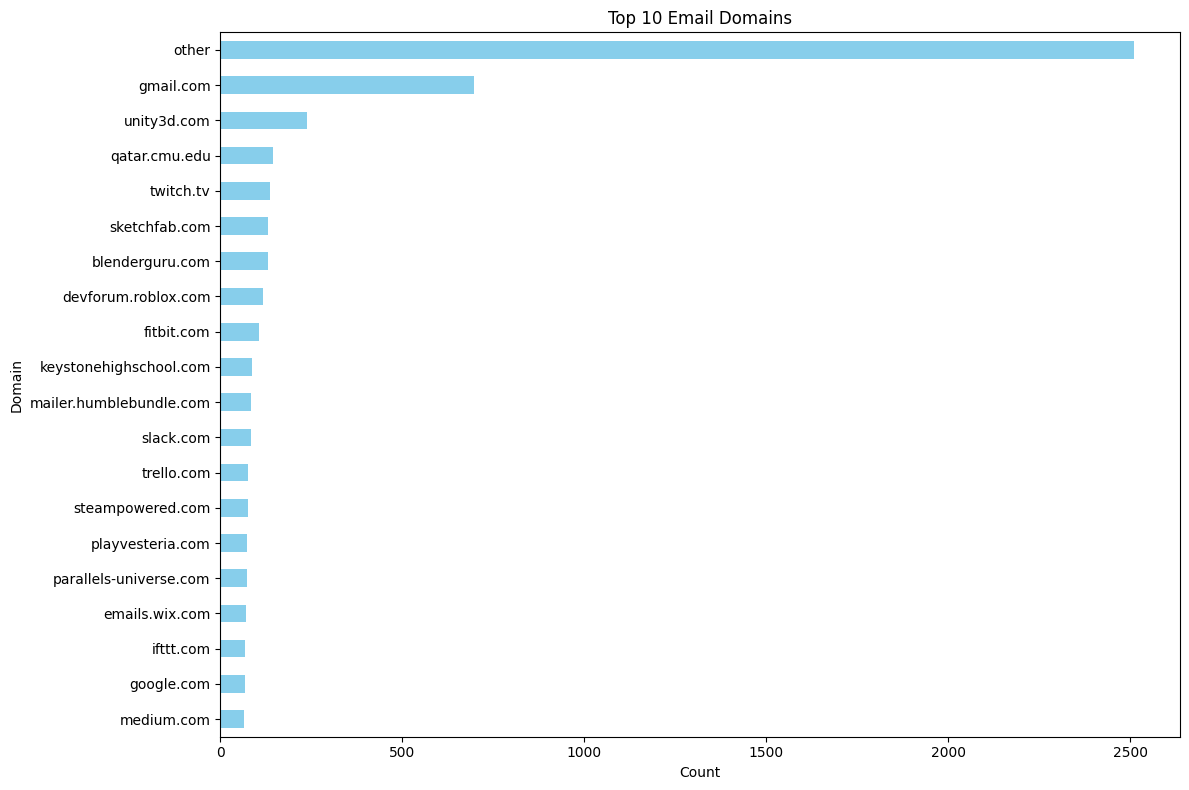

In [59]:
domain_counts = messages['domain'].value_counts()
top_domains = domain_counts.nlargest(19)
other_count = domain_counts[~domain_counts.index.isin(top_domains.index)].sum()
top_10_domains = pd.concat([top_domains, pd.Series({'other': other_count})])

plt.figure(figsize=(12, 8))
top_10_domains.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Email Domains')
plt.xlabel('Count')
plt.ylabel('Domain')
plt.tight_layout()

plt.show()


## Thread Identification

In [71]:
messages[messages['plain_text_body'].str.contains('We are excited to inform you that our Summer Workshop Program', na=False)]

,global_message_id,folder_id,from_address_id,provider_email_id,creation_time,submit_time,delivery_time,sender_name,in_reply_to,subject,plain_text_body,rich_text_body,html_body,first_in_thread,previous_message_id,domain,language,spam_score,from_internal_domain,subject_prefix
id,,,,,,,,,,,,,,,,,,,,
1,CANc0Yq66py_2t28pJ0H6E47s_BRZv1qR6O9=KFp2wqUC+...,1,1,2097188,2024-07-02 08:27:34,2024-06-30 05:06:15,2024-06-30 05:06:26,Mohammed Alsahal,CANc0Yq7Oy8un7hjwvQsEJyum4-p905KNjfPscOpabNgtC...,QSTP summer Workshops Program,"**_Reminder!_**\n\n \n\nOn Sat, 29 Jun 2024 a...",None,"<div dir=""ltr""><div dir=""auto""><b><font color=...",False,<CANc0Yq7Oy8un7hjwvQsEJyum4-p905KNjfPscOpabNgt...,gmail.com,None,None,False,None


In [41]:
sample = messages[['global_message_id', 'in_reply_to', 'subject', 'sender_name', 'delivery_time', 'plain_text_body']][messages['global_message_id'].notna()][messages['in_reply_to'].notna()].head(1)
print(f"Global Message ID: {sample['global_message_id'].item()}")
print(f"In Reply To: {sample['in_reply_to'].item()}")
print(sample['plain_text_body'].item())

Global Message ID: CANc0Yq66py_2t28pJ0H6E47s_BRZv1qR6O9=KFp2wqUC+WDzAA@mail.gmail.com
In Reply To: CANc0Yq7Oy8un7hjwvQsEJyum4-p905KNjfPscOpabNgtC1JZmQ@mail.gmail.com
**_Reminder!_**

  

On Sat, 29 Jun 2024 at 6:06 PM Mohammed Alsahal <m7mdalsahal@gmail.com> wrote:  

> Dears Interns,
>
> Greetings,
>
> We are excited to inform you that our Summer Workshop Program will commence
> tomorrow with our first workshop titled "Discover QSTP Where Ideas Become
> Reality" presented by Mrs. Haifa Al Abdullah. As these workshops are part of
> your field training, they are paid opportunities. Your attendance at the
> workshop will count as paid working hours. ** _Therefore, please register by
> scanning the QR code provided in the workshop poster as attendance is
> mandatory._**
>
> Best regards,
>
> Mohammed Al-Hafiz




In [16]:
# Get all non-null 'in_reply_to' values
in_reply_to_values = messages['in_reply_to'].dropna().unique()

# Check which of these values exist in the index (global_message_id)
matching_ids = messages.index.intersection(in_reply_to_values)

print(f"Total number of messages: {len(messages)}")
print(f"Number of unique non-null 'in_reply_to' values: {len(in_reply_to_values)}")
print(f"Number of 'in_reply_to' values that match a 'global_message_id': {len(matching_ids)}")

if len(matching_ids) > 0:
    print("\nExample of a matching pair:")
    example_id = matching_ids[0]
    print(f"global_message_id: {example_id}")
    print(f"Corresponding 'in_reply_to' from another message: {messages[messages['in_reply_to'] == example_id].index[0]}")
else:
    print("\nNo matching pairs found.")

Total number of messages: 5039
Number of unique non-null 'in_reply_to' values: 520
Number of 'in_reply_to' values that match a 'global_message_id': 0

No matching pairs found.


In [17]:
def find_thread_root(message_id, df):
    visited = set()
    current_id = message_id
    while current_id in df.index and pd.notna(df.loc[current_id, 'in_reply_to']):
        if current_id in visited:
            # We've encountered a loop, break it
            return current_id, True
        visited.add(current_id)
        current_id = df.loc[current_id, 'in_reply_to']
    
    # Check if the thread is broken
    is_broken = current_id not in df.index and pd.notna(current_id)
    
    return current_id, is_broken

threads = {}

for message_id in messages.index:
    root_id, is_broken = find_thread_root(message_id, messages)
    
    if root_id not in threads:
        threads[root_id] = {'is_broken': is_broken}

threads_df = pd.DataFrame.from_dict(threads, orient='index', columns=['thread_is_broken'])
threads_df.index.name = 'thread_id'

messages['thread_id'] = messages.apply(lambda row: find_thread_root(row.name, messages)[0], axis=1)

In [18]:
print(f"Number of threads: {len(threads_df)}")
print(f"Number of broken threads: {threads_df['thread_is_broken'].sum()}")
print(f"Number of messages: {len(messages)}")

Number of threads: 0
Number of broken threads: 0
Number of messages: 5039
